# import library

In [1]:
import numpy as np
import ot
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.cluster import SpectralClustering
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
from HOTDA import *

warnings.filterwarnings("ignore")
%matplotlib notebook


# matrice de rotation

In [2]:
def rotationMat(rotTheta):
    return np.array([[np.cos(rotTheta), -np.sin(rotTheta)], 
                     [np.sin(rotTheta), np.cos(rotTheta)]])

# Moons data

In [17]:
class Model5:
    def __init__(self,kernel='rbf'):
        self.kernel=kernel
        self.classifier_linear=svm.SVC()
        self.theta=0
        self.deg=0
        
    def fit(self,X,y,X_test,deg):
        self.deg=deg
        self.theta=  np.deg2rad(self.deg)
        self.rotMat = rotationMat(self.theta)
        self.X = X - np.mean(X, axis = 0)
        self.y=y
        self.X_test = X_test - np.mean(X_test, axis = 0)
        self.X_test = np.dot(self.X_test, self.rotMat.T)

        self.kmeans = SpectralClustering(n_clusters=2, eigen_solver='arpack', assign_labels='kmeans',affinity="nearest_neighbors").fit(self.X_test)
        S,a,mu,self.y_Transported_S=Source_target_processing(self.X,self.y)
        T,b,nu,yxyys=Source_target_processing(self.X_test,self.kmeans.labels_)  
        HOT,W=Hot(S,a,mu,T,b,nu,0.1,0.1)
        self.X_Transported_S=Mapping(S,T,a,b,HOT)
        self.classifier_linear = svm.SVC(kernel=self.kernel)
        self.classifier_linear.fit(self.X_Transported_S,self.y_Transported_S)
        
        
    def predict(self,X_test,y_t):
        self.y_test=y_t
        return self.classifier_linear.score(self.X_test,y_t)
    
    def plot1(self):
        self.x_s_plt=[num for elem in self.X[:,:1].tolist() for num in elem]
        self.y_s_plt=[num for elem in self.X[:,1:2].tolist() for num in elem]
        self.col_s_plt=self.y


        self.x_test_plt=[num for elem in self.X_test[:,:1].tolist() for num in elem]
        self.y_test_plt=[num for elem in self.X_test[:,1:2].tolist() for num in elem]
        self.col_test_plt=self.y_test.tolist()

        self.x_test=[num for elem in self.X_test[:,:1].tolist() for num in elem]
        self.y_test=[num for elem in self.X_test[:,1:2].tolist() for num in elem]
        self.col__prj_plt=self.y_test
        
        plt.figure()
        plt.subplot(2, 2, 1)
        plt.title('les donnes source sans rotation',fontsize=8)
        plt.scatter(self.x_s_plt, self.y_s_plt, c=self.col_s_plt, cmap='viridis', linewidth=0.5);

        plt.subplot(2, 2, 3)
        plt.title('\n les donnes target avec rotation de '+str(self.deg)+' degree',fontsize=8)
        plt.scatter(self.x_test_plt, self.y_test_plt, c=self.col_test_plt, cmap='viridis', linewidth=0.5);
        plt.show()
        
    def plot2(self):
        self.x=[elem[0] for elem in self.X_Transported_S]
        self.y=[elem[1] for elem in self.X_Transported_S]
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.title('les donnes source transporter',fontsize=8)
        plt.scatter(self.x,self.y, c=self.y_Transported_S, linewidth=0.5);

        plt.subplot(1, 2, 2)
        plt.title(u' \n \n \n les donnes target avec rotation de \n '+str(self.deg)+' degree et kernel RBF',fontsize=8)
        plt.scatter(self.x_test, self.y_test, c=self.col_test_plt, cmap='viridis', linewidth=0.5);
        plt.show()
    def plot3(self): 
            fig, (ax1, ax2) = plt.subplots(1, 2)
            plt.title('les centroides des donnes avec rotation et transformation RBF avec les vrais label',fontsize=8)

            ax1.scatter(self.x_test_plt, self.y_test_plt, c=self.col_test_plt, cmap='viridis', linewidth=0.1);

            plt.title('les centroides des donnes avec rotation et transformation RBF avec les label predicte',fontsize=8)
            plt.scatter(self.x_test_plt,self.y_test_plt, c=self.kmeans.labels_, cmap='viridis', linewidth=0.1);
            plt.show()
    def plot4(self):
        plt.figure()
        plt.scatter(self.x, self.y,c=self.y_Transported_S,label="les donnees source transporter", marker = 'x')
        plt.scatter(self.x_test_plt, self.y_test_plt, c=self.col_test_plt,  marker = 'o',label="les donnes target avec rotation de \n 90 degree et kernel RBF")
        plt.legend(loc='best')
        plt.show()
        
        
    def plot5(self):  
        self.x0=self.x[:150]
        self.y0=self.y[:150]
        self.x1=self.x[150:]
        self.y1=self.y[150:]
        plt.figure()
        h = .002
        x_min, x_max = -2 ,2
        y_min, y_max = -3 , +3
        xx, yy =np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = self.classifier_linear.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, cmap='Blues')
        sns.kdeplot(self.x0, 
            self.y0, color='b',
            shade=True,
            cmap="Blues", shade_lowest=False,thresh=0.37, levels=1000 )
        sns.kdeplot(self.x1,
                    self.y1, shade=True, 
                    cmap="Reds",color='r', shade_lowest=False,thresh=0.37, levels=1000)
        x1 = []
        x2 = []
        for i in range(0, len(self.col_s_plt)) :
            if self.col_s_plt[i] == 0 :
                x1.append(self.x_s_plt[i])
                x2.append(self.y_s_plt[i])
        plt.scatter(x1,x2, c='blue',  marker = '.')
        x1 = []
        x2 = []
        for i in range(0, len(self.col_s_plt)) :
            if self.col_s_plt[i] == 1 :
                x1.append(self.x_s_plt[i])
                x2.append(self.y_s_plt[i])
        plt.scatter(x1,x2, c='red',  marker = '.')
        plt.xlim([-1.5, 1.5])
        plt.ylim([-2, 2])

        
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.09)

        plt.scatter(self.x_test_plt, self.y_test_plt, c='gray',marker = '.', linewidth=0.5);
        
        plt.show()
        

In [18]:
X, y = datasets.make_moons(300, noise= 0.05) # il a genere 300 pts de moons avec leur etiquette
X_T,y_T=datasets.make_moons(1000, noise= 0.05)

In [5]:
our_methode = []
methode_sans_DA = []
rotations = []
S=[]
V=[]
for degre in range(0, 91, 10):
    for i in range(10):
        X, y = datasets.make_moons(300, noise= 0.05) # il a genere 300 pts de moons avec leur etiquette
        X_T,y_T=datasets.make_moons(1000, noise= 0.05)
        model=Model5()
        model.fit(X, y,X_T,degre)
        S.append(model.predict(X_T,y_T))
        m=svm.SVC()
        m.fit(X, y)
        X_T_transforme=np.dot(X_T, rotationMat(np.deg2rad(degre)).T)
        V.append(m.score(X_T_transforme,y_T))
    our_methode.append(np.array(S).mean())
    rotations.append(degre)
    #     model.plot1()
    #     model.plot2()
    #     model.plot5()
        
    methode_sans_DA.append(np.array(V).mean())

In [6]:
df = pd.DataFrame(
    {'our_methode': our_methode,
     'methode_sans_DA': methode_sans_DA,
     'rotations': rotations
    }
)
df.set_index('rotations')
df

,our_methode,methode_sans_DA,rotations
0,1.000000,1.000000,0
1,1.000000,0.999900,10
2,1.000000,0.963933,20
3,1.000000,0.897425,30
4,1.000000,0.852280,40
5,0.999983,0.818450,50
6,0.998871,0.789971,60
7,0.998637,0.764725,70
8,0.998167,0.742367,80
9,0.977650,0.722120,90


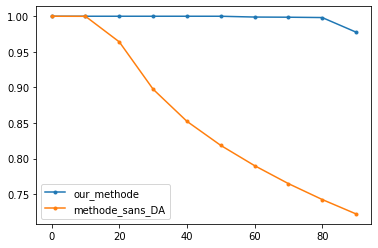

In [7]:
plt.figure()
plt.plot(df[['rotations']],df[['our_methode']],'.-',label="our_methode")
plt.plot(df[['rotations']],df[['methode_sans_DA']],'.-',label="methode_sans_DA")
plt.legend(loc='best')
plt.show()

In [19]:
model=Model5()
model.fit(X, y,X_T,80)

In [20]:
model.predict(X_T,y_T)

0.999

<IPython.core.display.Javascript object>


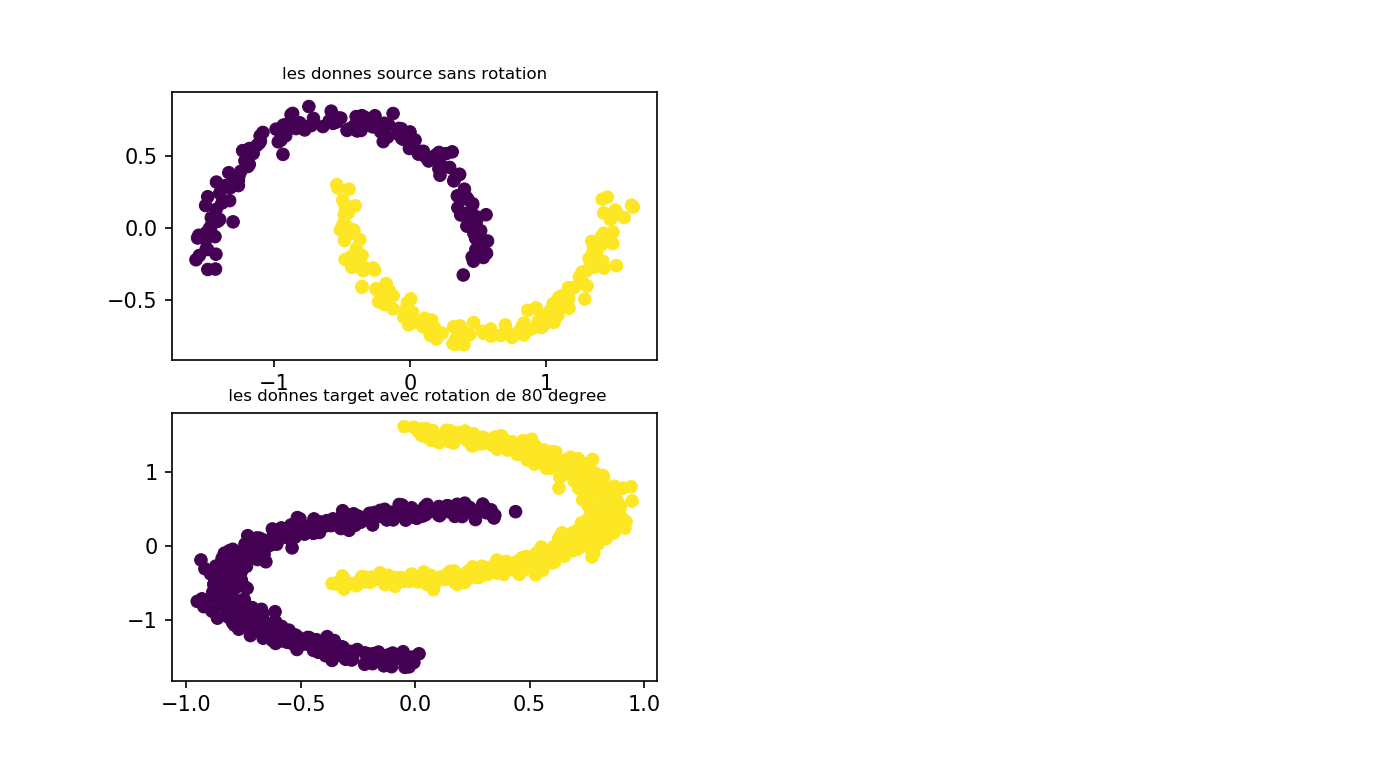

In [21]:
model.plot1()

<IPython.core.display.Javascript object>


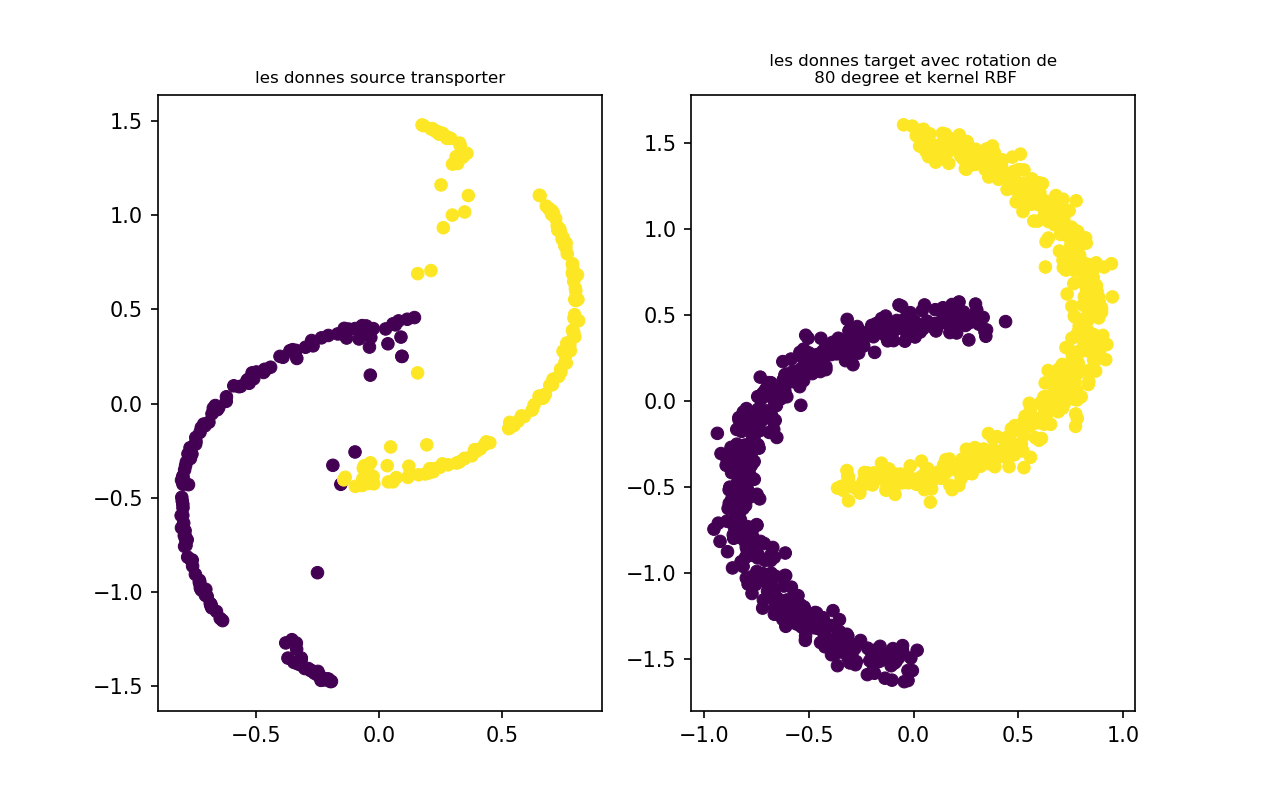

In [22]:
model.plot2()

<IPython.core.display.Javascript object>


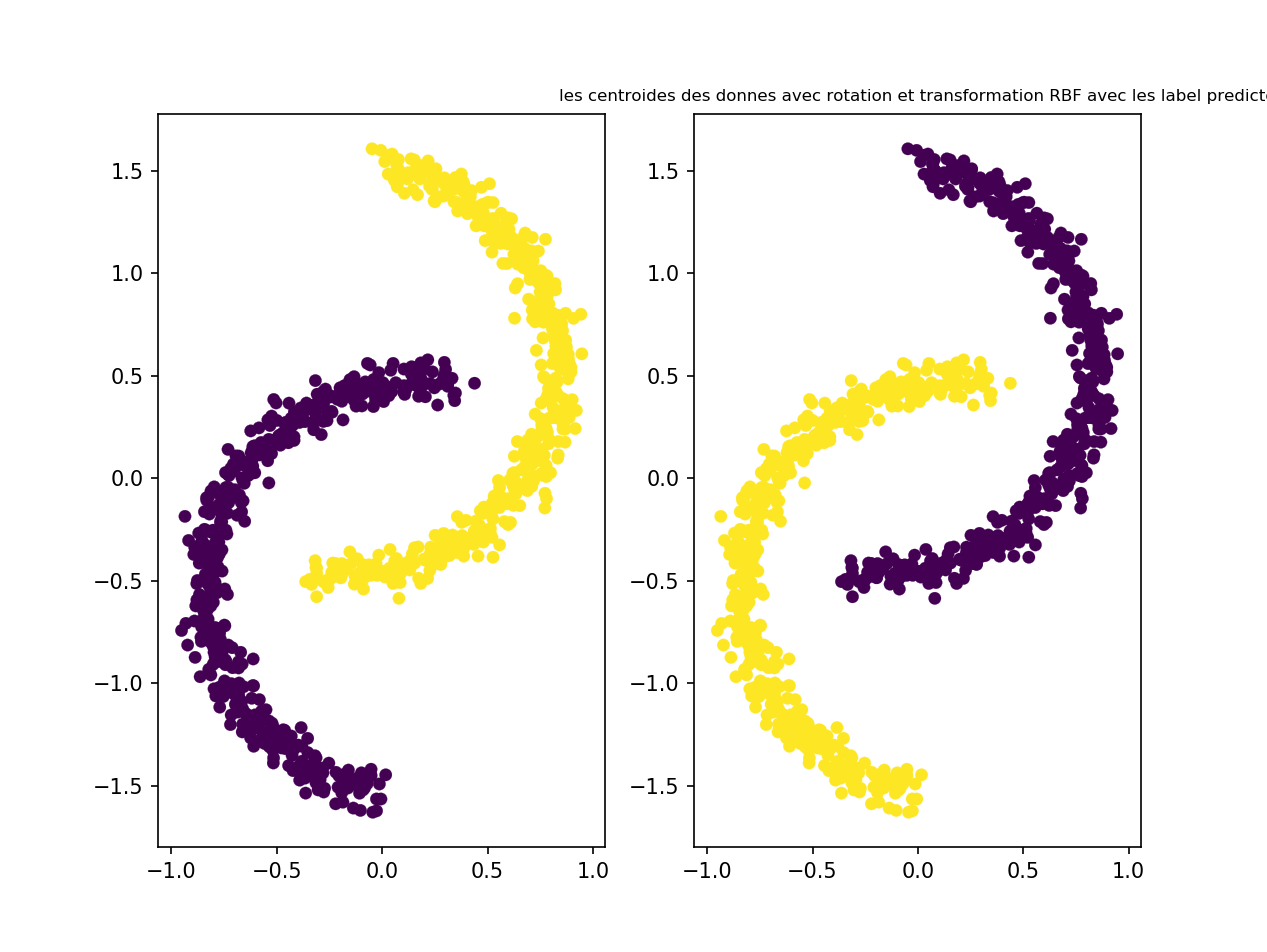

In [23]:
model.plot3()

<IPython.core.display.Javascript object>


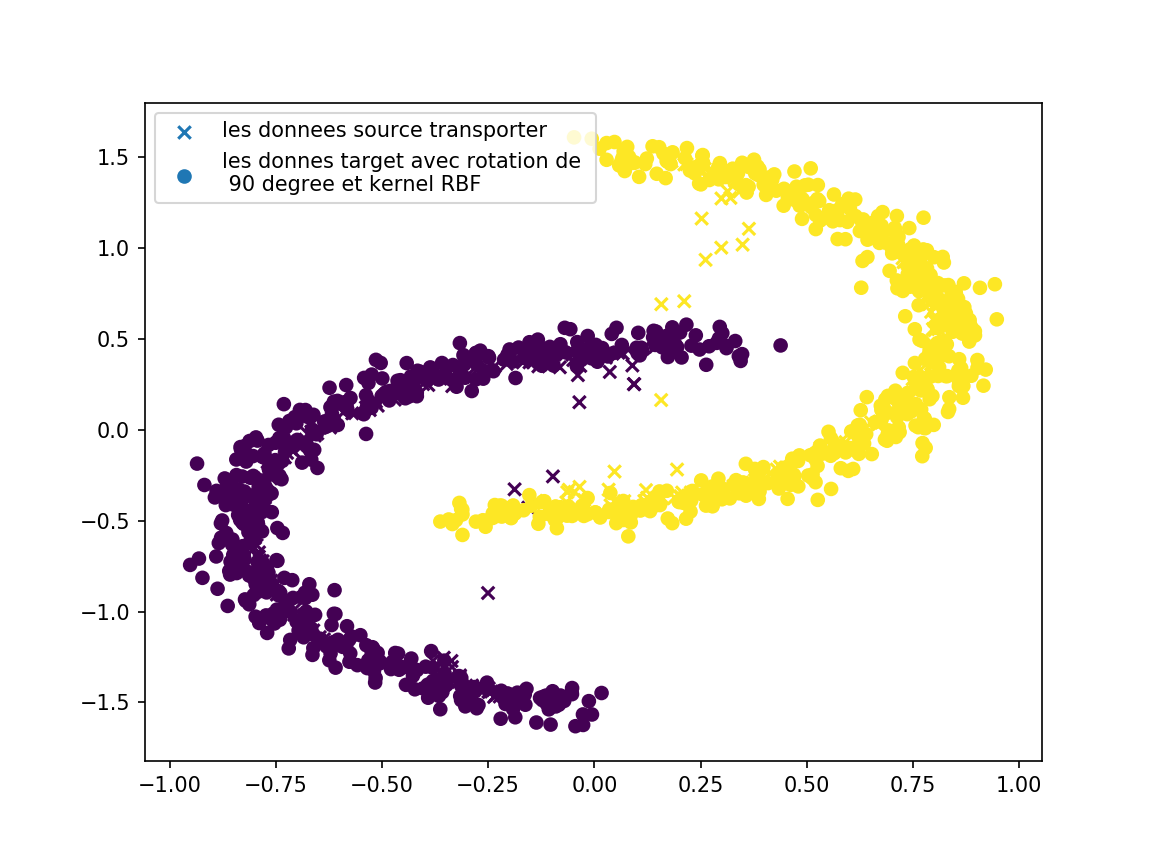

In [24]:
model.plot4()

<IPython.core.display.Javascript object>


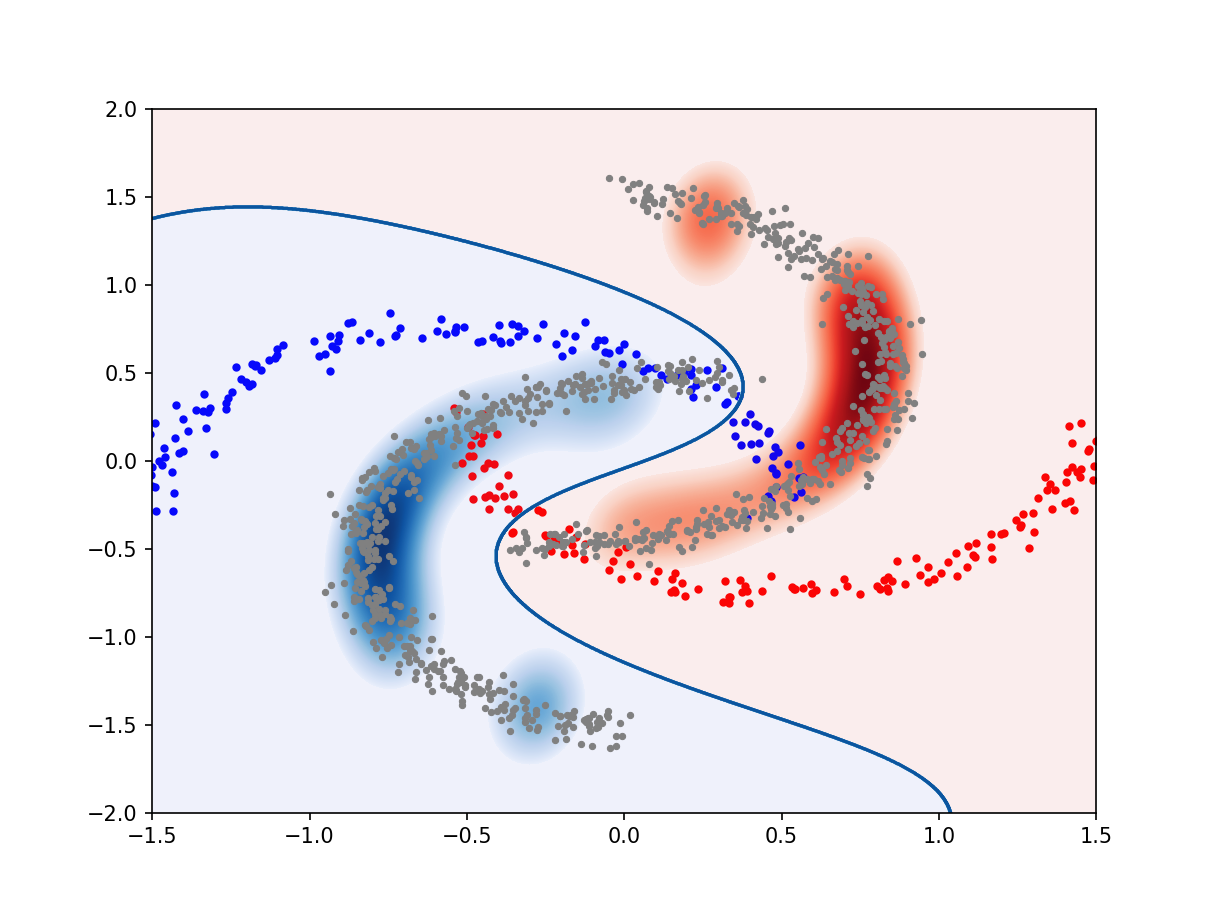

In [25]:
model.plot5()